# Pneumonia Prediction using Convulational Neural Network

The images trained, tested and validated for the neural network are chest X-Ray images. The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, I establish a diagnostic tool based on a deep-learning framework for the screening of patients with common treatable blinding retinal diseases.

![](http://miro.medium.com/max/1838/1*t-_EXQ3tlb8KOx6H7HN09A.jpeg)

* The **normal** chest X-ray depicts clear lungs without any areas of abnormal opacification in the image. 
* **Bacterial pneumonia** typically exhibits a focal lobar consolidation around upper lobes (white arrows)
* **Viral pneumonia** manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

## Importing libraries

In [2]:
!pip install gradio

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

## Data Preprocessing

**Getting training, validation and testing data set**

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
train = get_data('../input/chest-xray-pneumonia/chest_xray/train')
test = get_data('../input/chest-xray-pneumonia/chest_xray/test')
val = get_data('../input/chest-xray-pneumonia/chest_xray/val')

**Splitting x and y labels of training, validation and testing dataset**

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
positives=[]
negatives=[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

In [8]:
plt.bar(labels, [len(negatives), len(positives)], color=["green", "blue"])
plt.title("Cases count in training data set")
plt.ylabel("count")
plt.show()

In [9]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Normal")
plt.show()

**Performing a grayscale normalization to reduce the effect of illumination's differences.**

In [10]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

**Resizing the data for CNN training and testing**

In [11]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
x_test[0].shape

In [13]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

## Data augmentation

In order to avoid overfitting problem, we can expand artificially our dataset. This can be done by altering the training data with small transformations to reproduce the variations. 

Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [30]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [31]:
model.compile(optimizer = "rmsprop" , 
            loss = 'binary_crossentropy' , 
            metrics = ['accuracy'])
# model.summary()

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

In [33]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 10 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = learning_rate_reduction)

In [19]:
model.save_weights('kaggle/saved_model_ai/pneumoniadetection')

### Evaluation Metrics

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [21]:
epochs = list(range(10))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
predictions = model.predict(x_test) 
for i in range(len(predictions)): 
    predictions[i] = 1 if predictions[i]>0.5 else 0

In [23]:
print(classification_report(y_test, 
                            predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

### Confusion Matrix

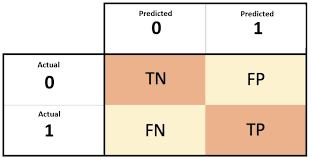

In [24]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
cm

In [25]:
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels = labels,yticklabels = labels)
plt.show()

In [26]:
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(-1, 150, 150, 1)
    isPneumonic = model.predict(img)[0]
    imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
    return imgClass

In [27]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

In [28]:
img = gradio.inputs.Image(shape=(150, 150))
label = gradio.outputs.Label(num_top_classes=1)

In [34]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray",
                            inputs = img,
                            outputs = label,
                            interpretation = "default")
interface.launch(debug=True, share=True)